# Importing 2D datasets as materials in Salvus

This notebook will demonstrate how to import 2D data into a Salvus material,
and use it to create a simulation.

## Conforming to structure in wave propagation simulations

Note that this approach, and in general, Salvus, won't conform to whatever
boundaries there are in this spatial dataset. For that, we refer to specialized
software. However, we find that when considering elastic wave behaviour, the
wavelength of the phases determines what is sensed, and thus confrming to grain
boundaries is not important for low frequency signals, whereas for high
frequency signals that do sense grains (or any variation) with more
sensitivity, those are naturally also more accurately meshed due to the
increased mesh resolution at higher frequencies.

To convert a EBSD map to angles, we'll assume the data is coded as **hue** in image data. To covnert RGB values to hue, we'll use OpenCV. However, any way you can get hue data into a XArray DataArray with spatial information will be valid.

In [1]:
# Install what isn't included in the standard Salvus environment
!pip install opencv-python



Now on to our typical imports:

In [1]:
import pathlib 

import cv2
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from PIL import Image

import salvus.namespace as sn

from salvus.toolbox.helpers.wavefield_output import (
    WavefieldOutput,
    wavefield_output_to_xarray,
)

SITE = "local"
RANKS = 8

--> Server: 'https://l.mondaic.com/licensing_server', User: 'bristol.support', Group: 'UniversityOfBristol'.
--> Negotiating 1 license instance(s) for 'SalvusMesh' [license version 1.0.0] for 1 seconds ...
--> Success! [Total duration: 0.47 seconds]


Load the image using PIL and convert it to an RGB numpy array. 

In [8]:
# Load and Display Image

# Load the image using PIL
img = Image.open('./Steel grain map.jpg')

# Convert the image to an RGB numpy array
rgb_img = np.array(img.convert('RGB'))

# Display the shape of the array
print(rgb_img.shape)

(775, 1033, 3)


Convert the RGB image to HSV using OpenCV.

In [9]:
# Convert Image to HSV

# Convert the RGB image to HSV using OpenCV
hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV).astype(np.float32)


Let's now check how the grain orientations are distributed **per pixel** (not per grain).

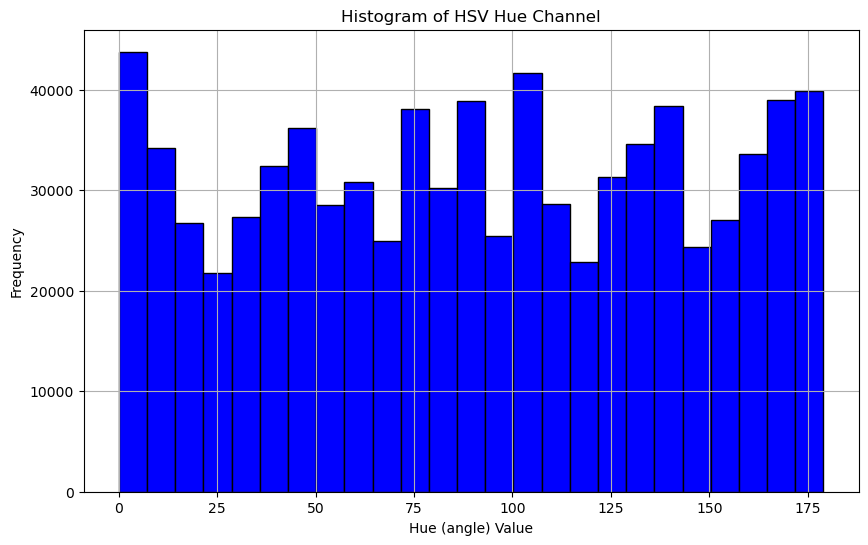

In [10]:
# Plot Histogram of HSV Values

# Plot a histogram of the HSV image's hue channel using matplotlib
plt.figure(figsize=(10, 6))
plt.hist(hsv_img[..., 0].flatten(), bins=25, color='blue', edgecolor='black')
plt.title('Histogram of HSV Hue Channel')
plt.xlabel('Hue (angle) Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [4]:
hsv_img.shape


(775, 1033, 3)

To use spatial data in **SalvusMaterial** it has to have some coordinate
relationship, i.e. we need to know where each pixel goes. I now **assume** that
the image I passed is defined in the domain $[0,1] \times [0,1]$. When you do
this, please check that DataArray construction interprets your data correctly.


Now we create an xarray DataArray for the orientation data using only the hue
values.

In [11]:
orientation_data = xr.DataArray(
    hsv_img[..., 0],  # Use the hue channel from the HSV image
    coords={
        "x": np.linspace(0, 1, hsv_img.shape[0]),  # Create x coordinates
        "y": np.linspace(0, 1, hsv_img.shape[1])   # Create y coordinates
    },
    dims=["x", "y"]  # Define the dimensions
)

# Display the orientation data array
orientation_data

<xarray.DataArray (x: 775, y: 1033)> Size: 3MB
array([[ 56.,  57.,  59., ...,  42.,  43.,  43.],
       [ 55.,  56.,  58., ...,  41.,  42.,  42.],
       [ 53.,  54.,  57., ...,  41.,  41.,  41.],
       ...,
       [ 91.,  91.,  91., ..., 135., 138., 142.],
       [ 91.,  90.,  90., ..., 136., 139., 146.],
       [ 91.,  91.,  91., ..., 138., 142., 150.]], dtype=float32)
Coordinates:
  * x        (x) float64 6kB 0.0 0.001292 0.002584 ... 0.9974 0.9987 1.0
  * y        (y) float64 8kB 0.0 0.000969 0.001938 0.002907 ... 0.9981 0.999 1.0

Plot the orientation data using xarray's plot function.

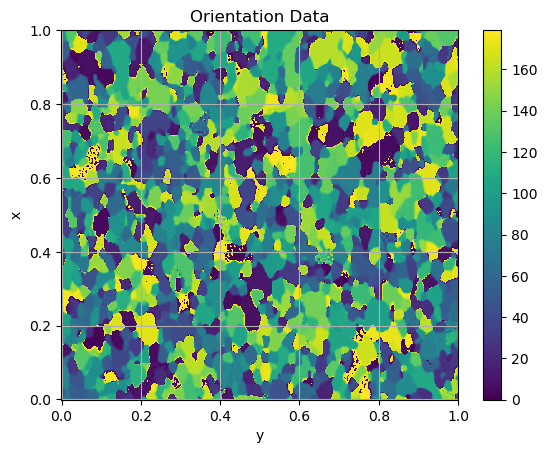

In [6]:
orientation_data.plot()

plt.title('Orientation Data')
plt.grid(True)

<xarray.DataArray (x: 775, y: 1033)> Size: 3MB
array([[ 56.,  57.,  59., ...,  42.,  43.,  43.],
       [ 55.,  56.,  58., ...,  41.,  42.,  42.],
       [ 53.,  54.,  57., ...,  41.,  41.,  41.],
       ...,
       [ 91.,  91.,  91., ..., 135., 138., 142.],
       [ 91.,  90.,  90., ..., 136., 139., 146.],
       [ 91.,  91.,  91., ..., 138., 142., 150.]], dtype=float32)
Coordinates:
  * x        (x) float64 6kB 0.0 0.001292 0.002584 ... 0.9974 0.9987 1.0
  * y        (y) float64 8kB 0.0 0.000969 0.001938 0.002907 ... 0.9981 0.999 1.0

In [12]:


class Austenite:
    def __init__(self):
        # Define parameters
        self.RHO = 8100  # Density in kg/m^3
        self.C11 = 217.1e9  # Stiffness in Pa
        self.C13 = 144.4e9  # Stiffness in Pa
        self.C33 = 263.2e9  # Stiffness in Pa
        self.C44 = 82.4e9   # Stiffness in Pa
        self.C66 = 128.4e9  # Stiffness in Pa

        # Derived parameters
        self.C12 = self.C11 - 2 * self.C66  # Derived from the relationship
        self.C22 = self.C11                # Symmetry in TTI media
        self.C23 = self.C13                # Symmetry in TTI media
        self.C55 = self.C44                # Symmetry in TTI media
        self.ETA = self.calculate_eta()
        
        self.C = self.tensor()  
        self.params = self.parameters()


    def calculate_eta(self):

        # Calculate epsilon
        epsilon = (self.C11 - self.C33) / (2 * self.C33)

        # Calculate delta
        delta = ((self.C13 + self.C44) ** 2 - (self.C33 - self.C44) ** 2) / (2 * self.C33 * (self.C33 - self.C44))

        # Calculate eta
        eta = (epsilon - delta) / (1 + 2 * delta)
        return eta
    

    def density(self):
        return self.RHO

    def tensor(self):
        C = np.zeros((6,6))
        C[0,0] = self.C11
        C[0,1] = self.C12
        C[0,2] = self.C13
        C[1,1] = self.C22
        C[1,2] = self.C23
        C[2,2] = self.C33
        C[3,3] = self.C44
        C[4,4] = self.C55
        C[5,5] = (self.C11 - self.C12) / 2
        
        C = (C + C.T) / 2.0
        return C
    
    def rotated_tensor(self, theta):
        return rotated_elasticityTensor(self.tensor(), theta)
        
    def parameters(self, theta=None):
        if not theta:
            return {
            'RHO': self.RHO,
            'VPV': np.sqrt(self.C33/self.RHO),
            'VPH': np.sqrt(self.C11/self.RHO),
            'VSV': np.sqrt(self.C55/self.RHO),
            'VSH': np.sqrt(self.C66/self.RHO),
            'ETA': self.ETA}

        else:
            return TTI_velocity_from_tensor(self.rotated_tensor(theta), self.RHO)
        
        

    def rotated_parameters(self, theta):
        rotated_C = self.rotated_tensor(theta)
        return {
        "rho": self.RHO, 
        "c11": rotated_C[0, 0],
        "c12": rotated_C[0, 1],
        "c13": rotated_C[0, 2],
        "c14": rotated_C[0, 3],
        "c15": rotated_C[0, 4],
        "c16": rotated_C[0, 5],
        "c22": rotated_C[1, 1],
        "c23": rotated_C[1, 2],
        "c24": rotated_C[1, 3],
        "c25": rotated_C[1, 4],
        "c26": rotated_C[1, 5],
        "c33": rotated_C[2, 2],
        "c34": rotated_C[2, 3],
        "c35": rotated_C[2, 4],
        "c36": rotated_C[2, 5],
        "c44": rotated_C[3, 3],
        "c45": rotated_C[3, 4],
        "c46": rotated_C[3, 5],
        "c55": rotated_C[4, 4],
        "c56": rotated_C[4, 5],
        "c66": rotated_C[5, 5],
        }

matl_1 = Austenite()

In [13]:
matl = Austenite()
matl_ref = matl.rotated_parameters



In [14]:
RHO = 8100  # Density in kg/m^3
C11 = 217.1e9  # Stiffness in Pa
C13 = 144.4e9  # Stiffness in Pa
C33 = 263.2e9  # Stiffness in Pa
C44 = 82.4e9   # Stiffness in Pa

C66 = 128.4e9  # Stiffness in Pa

C12 = C11 - 2 * C66

matl_hex = sn.material.from_params(rho=RHO, c11=C11, c12=C12, c13=C13, c33=C33, c44=C44)


In [15]:
matl_ort = sn.material.elastic.triclinic.TensorComponents.from_material(matl_hex)
matl_ort 


Field,Type,Value (or range)
RHO,constant,8.1e+03
C11,constant,2.2e+11
C12,constant,-4e+10
C13,constant,1.4e+11
C14,constant,0
C15,constant,0
C16,constant,0
C22,constant,2.2e+11
C23,constant,1.4e+11
C24,constant,0


salvus.material.elastic.triclinic.TensorComponents

## Creating materials from datasets

The canonical way to create a material for a simulation via **SalvusMaterial**
would be to create materials with homogeneous parameters. However, this
interface also allows spatial variations via DataArray's (as well as a few
other approaches not discussed here: analytic parameters and array parameters).

This is exactly what we need to create a material that varies spatially. However, we only have one parameter that varies spatially (grain orientation), while the stiffness properties themselves are homogenous. We can still pass the homogeneous parameters as single numbers, while only the orientation is spatially varying.

In [19]:
orientation_of_grains = sn.material.orientation.ClockwiseAngle.from_params(angle_in_degrees=orientation_data)


In [16]:
# Define Material Properties

# Define the orientation of grains using salvus
orientation_of_grains = sn.material.orientation.ClockwiseAngle.from_params(angle_in_degrees=orientation_data)

material_unoriented = sn.material.elastic.hexagonal.TensorComponents.from_material(matl_hex)


# # Define the unoriented material properties using salvus
# material_unoriented = sn.material.elastic.hexagonal.Velocity.from_params(
#     rho=8100,  # Density in kg/m^3
#     eta=-0.20414567258641442,   # Anisotropy parameter
#     vpv=5700.33570594696,  # P-wave velocity in the vertical direction in m/s
#     vph=5177.110114320775,  # P-wave velocity in the horizontal direction in m/s
#     vsv=3189.4889098682943,  # S-wave velocity in the vertical direction in m/s
#     vsh=3981.438414926426   # S-wave velocity in the horizontal direction in m/s
# )

# Apply the orientation to the material properties
material_oriented = matl_hex.with_orientation(orientation_of_grains)


material_oriented.ds

<xarray.Dataset> Size: 42MB
Dimensions:           (x: 775, y: 1033)
Coordinates:
  * x                 (x) float64 6kB 0.0 0.001292 0.002584 ... 0.9987 1.0
  * y                 (y) float64 8kB 0.0 0.000969 0.001938 ... 0.9981 0.999 1.0
Data variables:
    RHO               (x, y) float64 6MB 8.1e+03 8.1e+03 ... 8.1e+03 8.1e+03
    C11               (x, y) float64 6MB 2.171e+11 2.171e+11 ... 2.171e+11
    C12               (x, y) float64 6MB -3.97e+10 -3.97e+10 ... -3.97e+10
    C13               (x, y) float64 6MB 1.444e+11 1.444e+11 ... 1.444e+11
    C33               (x, y) float64 6MB 2.632e+11 2.632e+11 ... 2.632e+11
    C44               (x, y) float64 6MB 8.24e+10 8.24e+10 ... 8.24e+10 8.24e+10
    ANGLE_IN_DEGREES  (x, y) float32 3MB 56.0 57.0 59.0 ... 138.0 142.0 150.0

When we look at the output above, we see that each grain still has the same elastic tensor, if not considering the orientation. However, due to their orientation, the hexagonal elastic tensors are rotated s.t. every grain becomes triclinic in the global coordinate system.

When dispatching this simulation, we need to convert the material so that it's rotations are all applied:

In [17]:

# Import additional material details from salvus
from salvus.material._details import material as md


# Convert the oriented material to solver form for 2D simulations
material1 = md.to_solver_form(material_oriented, ndim=2)

# Define a default orientation for comparison
orientation_of_grains_default = sn.material.orientation.ClockwiseAngle.from_params(angle_in_degrees=0)

# Convert the unoriented material with default orientation to solver form for 2D simulations
material2 = md.to_solver_form(material_unoriented.with_orientation(orientation_of_grains_default), ndim=2)

material1

Field,Type,Value (or range)
RHO,discrete,8.1e+03 to 8.1e+03
C11,discrete,2.2e+11 to 2.8e+11
C12,discrete,1.1e+11 to 1.4e+11
C13,discrete,-2.6e+10 to 2.6e+10
C22,discrete,2.2e+11 to 2.8e+11
C23,discrete,-2.6e+10 to 2.6e+10
C33,discrete,4.8e+10 to 8.2e+10


salvus.material.elastic.hexagonal._TensorComponents2D

This actually shows how now even entries that are not part of the original hexagonal tensor are non-zero.

## Creating meshes from materials
Define the simulation domain and mesh resolution using salvus.

In [18]:
# Define Simulation Domain and Mesh Resolution

# Unnecessary, but could be used to combine materials:
# layered_model1 = sn.layered_meshing.LayeredModel([material1])
# layered_model2 = sn.layered_meshing.LayeredModel([material2])


# Define the simulation domain using salvus
domain = sn.domain.dim2.BoxDomain.from_bounds(1, 1)

# Define the central frequency for the simulation
central_frequency = 50_000

# Define the mesh resolution using salvus
mesh_resolution = sn.MeshResolution(
    reference_frequency=central_frequency * 2,  # Reference frequency for the mesh
    elements_per_wavelength=1.5,  # Number of elements per wavelength
    model_order=2  # Model order for the mesh
)

# Create the mesh for the grains model using the defined domain and mesh resolution
mesh_grains = sn.layered_meshing.mesh_from_domain(
    domain=domain,
    model=material1,
    mesh_resolution=mesh_resolution
)


# Create the mesh for the no grains model using the defined domain and mesh resolution
mesh_no_grains = sn.layered_meshing.mesh_from_domain(
    domain=domain,
    model=material2,
    mesh_resolution=mesh_resolution
)


# Display one of the created meshes
mesh_grains

/home/oliver/miniforge3/envs/salvus/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


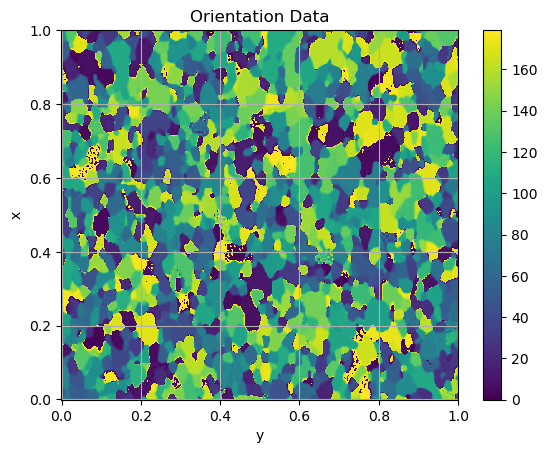

In [16]:
orientation_data.plot()

plt.title('Orientation Data')
plt.grid(True)

In [43]:
# Initialize Project

# Initialize a salvus project using the defined domain
project_name = "project_EBSD_grain_test"
domain = sn.domain.dim2.BoxDomain.from_bounds(1, 1)

# Create or load the project
p = sn.Project.from_domain(project_name, domain=domain, load_if_exists=True)

Accordion()

## Creating simulations
Define simulation configurations for the meshes with and without grains.

In [14]:
end_time = 0.00025
time_step_in_seconds=1.8e-07

stf = sn.simple_config.stf.Ricker(center_frequency=central_frequency)
event_configuration=sn.EventConfiguration(
        wavelet=stf,
        waveform_simulation_configuration=sn.WaveformSimulationConfiguration(
            time_step_in_seconds=time_step_in_seconds,
            end_time_in_seconds=end_time
        ),
    )



p += sn.UnstructuredMeshSimulationConfiguration(
    unstructured_mesh=mesh_grains,
    name="sc_mesh_grains",
    event_configuration=event_configuration,
)


# Define the simulation configuration for the mesh without grains
p += sn.UnstructuredMeshSimulationConfiguration(
    unstructured_mesh=mesh_no_grains,
    name="sc_mesh_no_grains",
event_configuration=event_configuration,
)


[2025-02-03 23:46:09,200] INFO: This exact entity is already part of the project. Nothing will be done. The comparison to the existing mesh was fairly expensive as it is (depending on the mesh size) a large amount of data that has to be compared. So best only add it once!
[2025-02-03 23:46:09,256] INFO: This exact entity is already part of the project. Nothing will be done. The comparison to the existing mesh was fairly expensive as it is (depending on the mesh size) a large amount of data that has to be compared. So best only add it once!


In [15]:
# Add Event to Project

# Define the source location and force components using salvus
source = sn.simple_config.source.cartesian.VectorPoint2D(x=0.5, y=0.5, fx=0, fy=1.0)

# Create an event with the defined source
p += sn.Event(
    event_name="event_1",  # Name of the event
    sources=source  # Source configuration
)

[2025-02-03 23:46:09,928] INFO: An event with name 'event_1' and identical content already exists in the project. Nothing will be done.


In [16]:
# Launch the simulation for the mesh with and without grains
for sim in p.simulations.list():
    p.simulations.launch(
        simulation_configuration=sim, 
        events="event_1",   
        site_name=SITE, 
        ranks_per_job=RANKS,
        delete_conflicting_previous_results=True,
        extra_output_configuration={
            "volume_data": {
                "sampling_interval_in_time_steps": int(end_time/time_step_in_seconds/2), 
                "fields": ["displacement"],  
            },
        }
    )

    p.simulations.query(block=True)


[2025-02-03 23:46:11,014] INFO: Data for 1 event(s) already exists. They will not be submitted again. The requested extra_output_configuration is fully contained in the existing results. If you really want to rerun the simulations, please delete the results first using p.simulations.delete_results().


VBox()

[2025-02-03 23:46:11,022] INFO: Data for 1 event(s) already exists. They will not be submitted again. The requested extra_output_configuration is fully contained in the existing results. If you really want to rerun the simulations, please delete the results first using p.simulations.delete_results().


VBox()

In [17]:
def vector_norm(x, dim, ord=None):
    """
    Vector norm for XArray.
    """
    return xr.apply_ufunc(
        np.linalg.norm, x, input_core_dims=[[dim]], kwargs={"ord": ord, "axis": -1}
    )



<xarray.DataArray (x: 775, y: 1033)> Size: 6MB
array([[0.31284916, 0.31843575, 0.32960894, ..., 0.23463687, 0.24022346,
        0.24022346],
       [0.30726257, 0.31284916, 0.32402235, ..., 0.22905028, 0.23463687,
        0.23463687],
       [0.29608939, 0.30167598, 0.31843575, ..., 0.22905028, 0.22905028,
        0.22905028],
       ...,
       [0.50837989, 0.50837989, 0.50837989, ..., 0.75418994, 0.77094972,
        0.79329609],
       [0.50837989, 0.5027933 , 0.5027933 , ..., 0.75977654, 0.77653631,
        0.81564246],
       [0.50837989, 0.50837989, 0.50837989, ..., 0.77094972, 0.79329609,
        0.83798883]])
Coordinates:
  * x        (x) float64 6kB 0.0 0.001292 0.002584 ... 0.9974 0.9987 1.0
  * y        (y) float64 8kB 0.0 0.000969 0.001938 0.002907 ... 0.9981 0.999 1.0

Finding enclosing elements (pass 1 of auto):   0%|          | 0/40000 [00:00<?, ?it/s]

Extracting wavefield to regular grid:   0%|          | 0/3 [00:00<?, ?it/s]

Finding enclosing elements (pass 1 of auto):   0%|          | 0/40000 [00:00<?, ?it/s]

Extracting wavefield to regular grid:   0%|          | 0/3 [00:00<?, ?it/s]

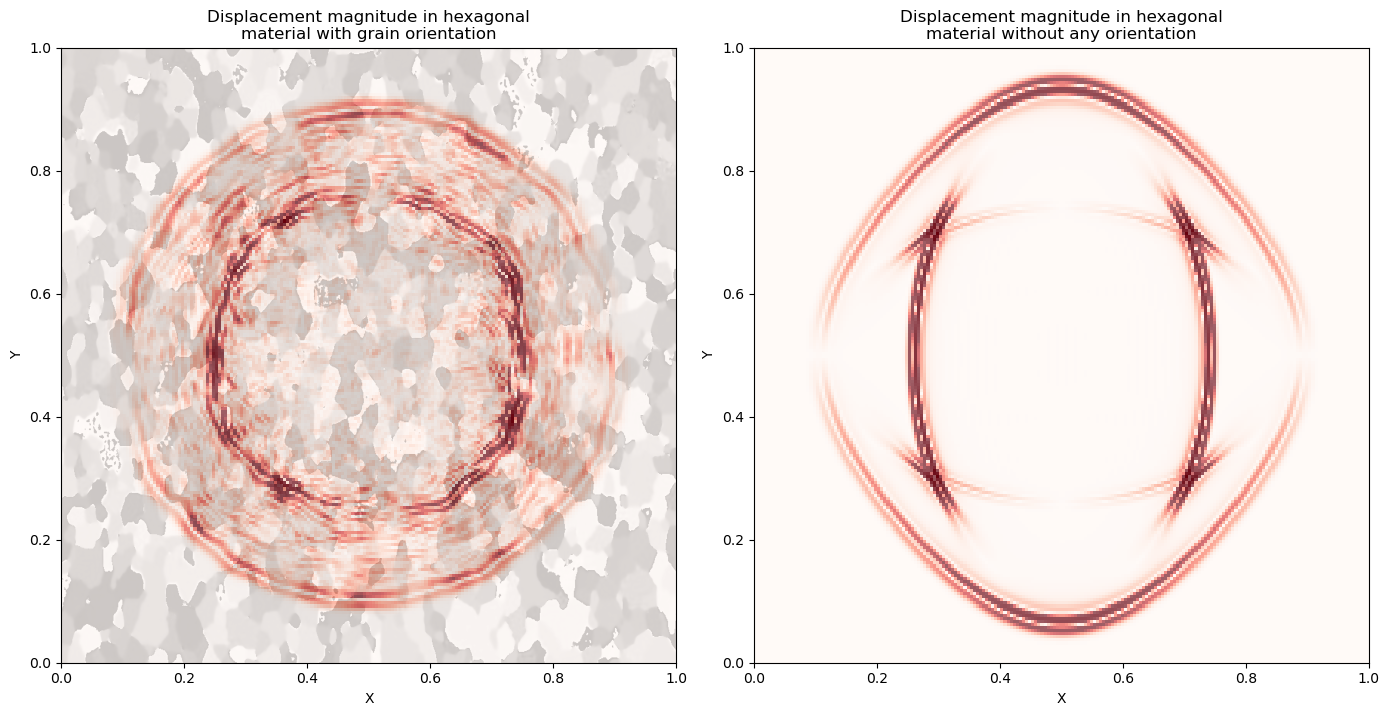

In [23]:

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

for i, sim in enumerate(p.simulations.list()):
    output_file = pathlib.Path(
        p.simulations.get_simulation_output_directory(
            sim, "event_1"
        ),
        "volume_data_output.h5",
    ).resolve()

    displacement = WavefieldOutput.from_file(output_file,
                            field="displacement",
                            output_type="volume")


    resolution = 200
    wavefields_as_xarray = wavefield_output_to_xarray(
        displacement,
        [
            np.linspace(0.0, 1.0, resolution),
            np.linspace(0.0, 1.0, resolution),
        ],
    ).T

    wavefield_data = vector_norm(
        wavefields_as_xarray, dim="c"
    ).sel(
        t=end_time, method="nearest"
    )
    wavefield_normalized = wavefield_data / np.max(np.abs(wavefield_data))


    if sim == "sc_mesh_grains":
        axs[i].imshow(orientation_data / orientation_data.max(), cmap='gray', extent=[0, 1, 0, 1], alpha=0.4)
        axs[i].set_title('Displacement magnitude in hexagonal\nmaterial with grain orientation')
    else:
        axs[i].set_title('Displacement magnitude in hexagonal\nmaterial without any orientation')


    wavefield_colormap = axs[i].imshow(wavefield_normalized, cmap='Reds', alpha=wavefield_normalized/2 + 0.5, vmax=0.25, extent=[0, 1, 0, 1])

    axs[i].set_xlabel('X')
    axs[i].set_ylabel('Y')

# Show the plot
plt.tight_layout() 
plt.show()

Seems like effectively, randomly oriented grains behave isotropically on a
macro scale.